In [733]:
%%capture
%pip install mne
%pip install pytorch-lightning

In [734]:
import scipy.io
import torch.nn as nn
import torch
import numpy as np

In [1391]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold


imagined_path = r"C:\Users\34679\Desktop\TFM\EEG Prepro\S-14\Tipo de Habla\tfr_imagined_data.npy"
silence_path = r"C:\Users\34679\Desktop\TFM\EEG Prepro\S-14\Tipo de Habla\tfr_silence_data.npy"
real_path = r"C:\Users\34679\Desktop\TFM\EEG Prepro\S-14\Tipo de Habla\tfr_real_data.npy"


imagined_data = np.load(imagined_path)
silence_data = np.load(silence_path)
real_data = np.load(real_path)

def convert_bool_to_int(data):
    if data.dtype == bool:
        data = data.astype(int)
    return data

def clean_data(data):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    return data


imagined_data = convert_bool_to_int(clean_data(imagined_data))
silence_data = convert_bool_to_int(clean_data(silence_data))
real_data = convert_bool_to_int(clean_data(real_data))


data_array = np.concatenate([imagined_data, silence_data, real_data], axis=0)


labels = np.array([0]*imagined_data.shape[0] + [1]*silence_data.shape[0] + [2]*real_data.shape[0])



X_train, X_test, y_train, y_test = train_test_split(data_array, labels, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

print("Dimensiones de X_train después de la transformación:", X_train.shape) 
print("Dimensiones de X_test después de la transformación:", X_test.shape) 



Dimensiones de X_train después de la transformación: (148, 501, 10)
Dimensiones de X_test después de la transformación: (38, 501, 10)


In [1392]:
# Definir la arquitectura del modelo ChronoNet
class Block(nn.Module):
    def __init__(self, inplace):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=inplace, out_channels=32, kernel_size=8, stride=2, padding=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x3 = self.relu(self.conv3(x))
        x = torch.cat([x1, x2, x3], dim=1)
        return x

class ChronoNet(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.block1 = Block(channel)
        self.block2 = Block(96)
        self.block3 = Block(96)
        self.gru1 = nn.GRU(input_size=96, hidden_size=32, batch_first=True)
        self.gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first=True)
        self.gru3 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        self.gru4 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        self.gru_linear = nn.Linear(96, 64) 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1984, 3) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.permute(0, 2, 1) 
        gru_out1, _ = self.gru1(x)
        gru_out2, _ = self.gru2(gru_out1)
        gru_out = torch.cat([gru_out1, gru_out2], dim=2)  
        gru_out3, _ = self.gru3(gru_out)
        gru_out = torch.cat([gru_out1, gru_out2, gru_out3], dim=2)  
        linear_out = self.relu(self.gru_linear(gru_out))  
        gru_out4, _ = self.gru4(linear_out.permute(0, 1, 2))  
        x = self.flatten(gru_out4)
        x = self.fc1(x)
        return x

input = (10,501,62)
model = ChronoNet(10)
device = torch.device("cpu")
model.to(device)

ChronoNet(
  (block1): Block(
    (conv1): Conv1d(10, 32, kernel_size=(2,), stride=(2,))
    (conv2): Conv1d(10, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv3): Conv1d(10, 32, kernel_size=(8,), stride=(2,), padding=(3,))
    (relu): ReLU()
  )
  (block2): Block(
    (conv1): Conv1d(96, 32, kernel_size=(2,), stride=(2,))
    (conv2): Conv1d(96, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv3): Conv1d(96, 32, kernel_size=(8,), stride=(2,), padding=(3,))
    (relu): ReLU()
  )
  (block3): Block(
    (conv1): Conv1d(96, 32, kernel_size=(2,), stride=(2,))
    (conv2): Conv1d(96, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv3): Conv1d(96, 32, kernel_size=(8,), stride=(2,), padding=(3,))
    (relu): ReLU()
  )
  (gru1): GRU(96, 32, batch_first=True)
  (gru2): GRU(32, 32, batch_first=True)
  (gru3): GRU(64, 32, batch_first=True)
  (gru4): GRU(64, 32, batch_first=True)
  (gru_linear): Linear(in_features=96, out_features=64, bias=True)
  (flatten): Flatten(

In [1393]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

import seaborn as sns


sns.set(style="whitegrid")

train_losses = []
train_accuracies = []
# Ciclo de entrenamiento (ejemplo)
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
    targets = torch.tensor(y_train, dtype=torch.long, device=device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

    # Guardar loss
    train_losses.append(loss.item())
    
    # Calcular accuracy en el conjunto de entrenamiento
    _, predicted_train = torch.max(outputs, 1)
    train_accuracy = (predicted_train == targets).sum().item() / len(targets)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}, Accuracy: {train_accuracy * 100:.2f}%")



# Evaluación del modelo en el conjunto de prueba
model.eval()
inputs_test = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
targets_test = torch.tensor(y_test, dtype=torch.long, device=device)
with torch.no_grad():
    outputs_test = model(inputs_test)
    _, predicted_test = torch.max(outputs_test, 1)

# Métricas de evaluación
test_accuracy = (predicted_test == targets_test).sum().item() / len(targets_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(targets_test.cpu().numpy(), predicted_test.cpu().numpy()))

Epoch [1/50], Loss: 1.1003
Epoch [1/50], Loss: 1.1003, Accuracy: 32.43%
Epoch [2/50], Loss: 1.1029
Epoch [2/50], Loss: 1.1029, Accuracy: 34.46%
Epoch [3/50], Loss: 1.0861
Epoch [3/50], Loss: 1.0861, Accuracy: 33.11%
Epoch [4/50], Loss: 1.0683
Epoch [4/50], Loss: 1.0683, Accuracy: 54.73%
Epoch [5/50], Loss: 1.0323
Epoch [5/50], Loss: 1.0323, Accuracy: 56.08%
Epoch [6/50], Loss: 0.9736
Epoch [6/50], Loss: 0.9736, Accuracy: 72.30%
Epoch [7/50], Loss: 0.9051
Epoch [7/50], Loss: 0.9051, Accuracy: 70.27%
Epoch [8/50], Loss: 0.8389
Epoch [8/50], Loss: 0.8389, Accuracy: 70.27%
Epoch [9/50], Loss: 0.7762
Epoch [9/50], Loss: 0.7762, Accuracy: 70.95%
Epoch [10/50], Loss: 0.7104
Epoch [10/50], Loss: 0.7104, Accuracy: 70.27%
Epoch [11/50], Loss: 0.6465
Epoch [11/50], Loss: 0.6465, Accuracy: 70.27%
Epoch [12/50], Loss: 0.6044
Epoch [12/50], Loss: 0.6044, Accuracy: 73.65%
Epoch [13/50], Loss: 0.5644
Epoch [13/50], Loss: 0.5644, Accuracy: 71.62%
Epoch [14/50], Loss: 0.5150
Epoch [14/50], Loss: 0.5150,

In [1394]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
gkf=GroupKFold()
from sklearn.metrics import classification_report

In [1395]:
# If problems search for True print(np.isnan(X_train).any(), np.isnan(X_test).any())
# print(np.isinf(X_train).any(), np.isinf(X_test).any())


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00        14

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Production Type Accuracy 'Imagined': 100.00%
Production Type Accuracy 'Silence': 92.31%
Production Type Accuracy 'Real': 100.00%


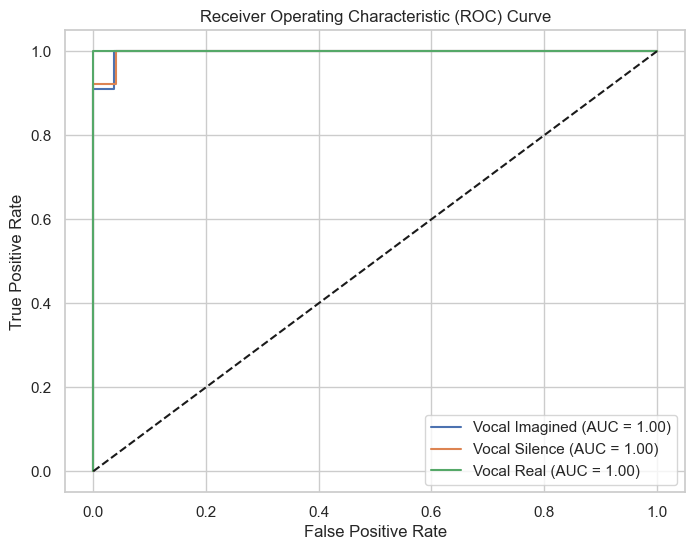

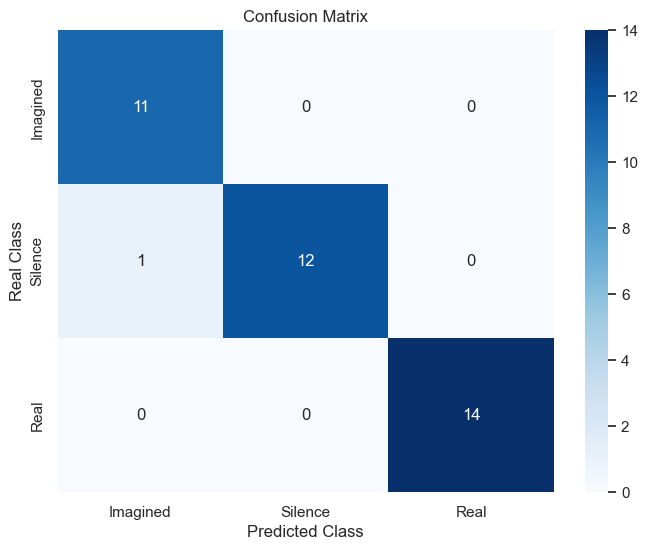

In [1396]:
import numpy as np
import torch
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical  # Asumiendo que usas Keras para to_categorical

# Obtener predicciones del conjunto de prueba
model.eval()
with torch.no_grad():
    inputs_test = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
    test_predictions = model(inputs_test).cpu().numpy()  # Obtener las predicciones y pasarlas a CPU
    test_pred_labels = np.argmax(test_predictions, axis=1)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, test_pred_labels))

# Accuracy por vocal
class_labels = ['Imagined','Silence', 'Real']
for i, label in enumerate(class_labels):
    # Filtrar las predicciones y las etiquetas verdaderas para cada vocal
    true_labels = np.array(y_test) == i
    pred_labels = np.array(test_pred_labels) == i
  
    # Calcular el accuracy para cada vocal
    accuracy_per_class = np.sum(pred_labels & true_labels) / np.sum(true_labels) if np.sum(true_labels) > 0 else 0  
    print(f"Production Type Accuracy '{label}': {accuracy_per_class * 100:.2f}%")
 # Curva ROC

num_classes = len(np.unique(y_test))
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    class_labels = ['Imagined','Silence', 'Real']
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Vocal {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()


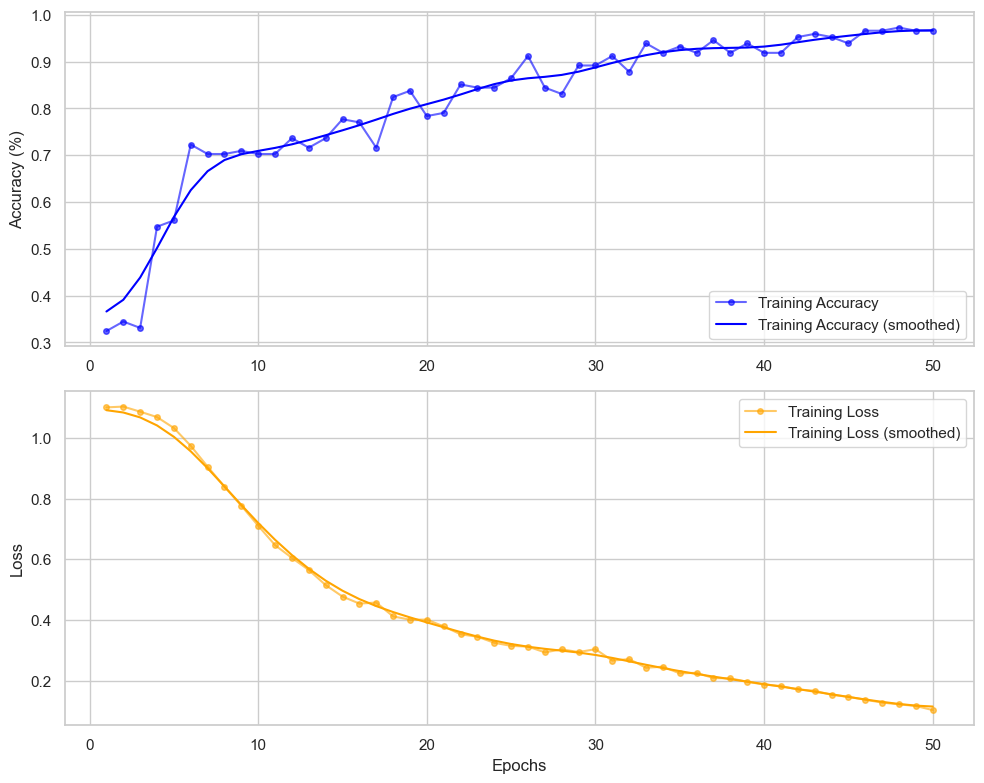

In [1397]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

# Configuración de estilo para Seaborn
sns.set(style="whitegrid")

# Asegúrate de que `train_losses` y `train_accuracies` contengan datos
if len(train_losses) == 0 or len(train_accuracies) == 0:
    raise ValueError("Las listas `train_losses` o `train_accuracies` están vacías.")

# Convertir listas a arrays de NumPy para suavizado y gráficos
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)
epochs = np.arange(1, len(train_losses) + 1)

# Suavizado de datos para una apariencia similar a la imagen proporcionada
smoothed_losses = gaussian_filter1d(train_losses, sigma=2)
smoothed_accuracies = gaussian_filter1d(train_accuracies, sigma=2)

# Crear gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de precisión
ax1.plot(epochs, train_accuracies, 'o-', label='Training Accuracy', color='blue', markersize=4, alpha=0.6)
ax1.plot(epochs, smoothed_accuracies, label='Training Accuracy (smoothed)', color='blue')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(loc='lower right')
ax1.grid(True)

# Gráfico de pérdida
ax2.plot(epochs, train_losses, 'o-', label='Training Loss', color='orange', markersize=4, alpha=0.6)
ax2.plot(epochs, smoothed_losses, label='Training Loss (smoothed)', color='orange')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


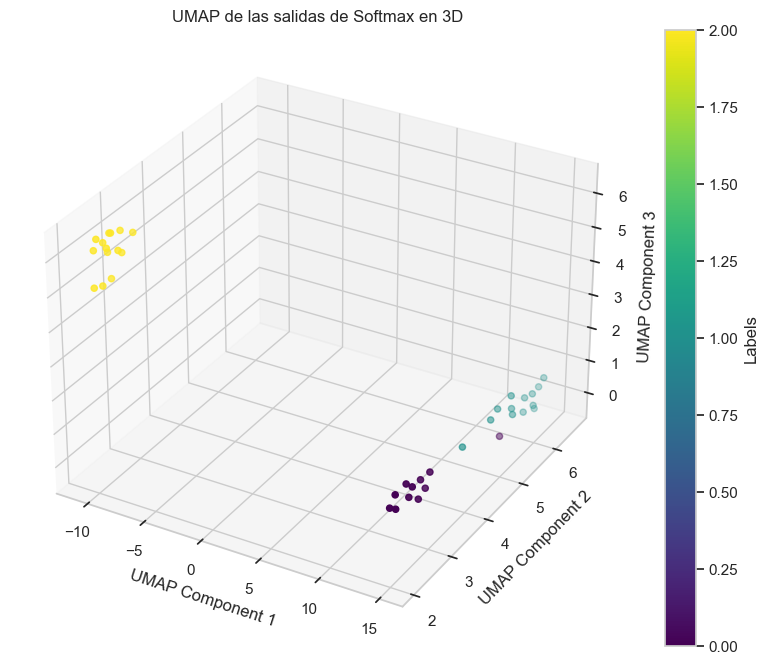

In [1398]:
%pip install umap
from umap import UMAP
import matplotlib.pyplot as plt

softmax_outputs = model(torch.tensor(X_test_scaled, dtype=torch.float32, device=device)).detach().cpu().numpy()

true_labels = y_test

#Dimensions
umap_model = UMAP(n_components=3)
X_umap = umap_model.fit_transform(softmax_outputs)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=true_labels, cmap='viridis')
plt.colorbar(sc, label='Labels')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.title('UMAP de las salidas de Softmax en 3D')
plt.show()


In [1399]:
import nbformat
from nbconvert import MarkdownExporter
import datetime
import os

# Función para exportar el notebook a Markdown con un nombre único
def export_notebook_to_markdown():
    # Cargar el notebook actual
    notebook_path = r"C:\Users\34679\Desktop\TFM\ChronoNet[3,3].ipynb"  # Reemplaza con la ruta de tu notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)
    
    # Configurar el exportador de Markdown
    md_exporter = MarkdownExporter()
    
    # Exportar el notebook a Markdown
    (body, resources) = md_exporter.from_notebook_node(notebook)
    
    # Crear un nombre de archivo único basado en la fecha y hora actuales
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f'Parti14_AllBands_{timestamp}.md'
    
    # Guardar el contenido Markdown en un archivo
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(body)
    
    print(f'Notebook exportado a {output_file}')

# Llamar a la función para exportar el notebook
export_notebook_to_markdown()


Notebook exportado a Parti14_AllBands_20240822_133102.md
